In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator, FixedLocator

In [2]:
def steering_angle_to_bin_idx(angle_degs, num_samples=512, bound=4.5):
    angle_rads = np.radians(angle_degs)
    bin_idx = (angle_rads) * (num_samples-1) / (bound*2) + (num_samples-1)/2
    return bin_idx

def bin_idx_to_steering_angle(bin_idx, num_samples=512, bound=4.5):
    angle_rads = (bin_idx - (num_samples-1)/2) * bound*2 / (num_samples-1)
    angle_degs = np.degrees(angle_rads)
    return angle_degs

degrees start idx: tensor(250)


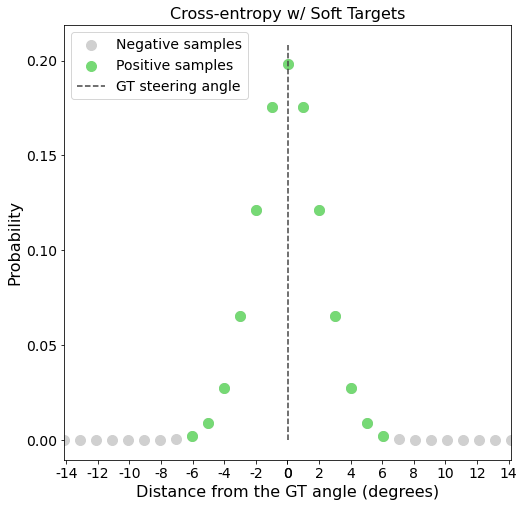

In [5]:
bound = 4.5
target = 0
probability_mass_covered = 0.999
n_samples = 513
temperature = 0.0025


fig, ax = plt.subplots(1, 1, figsize=(8, 8))

tick_formatter = FuncFormatter(lambda x, pos: int(bin_idx_to_steering_angle(x, num_samples=n_samples, bound=bound).round()))
bin_indices = steering_angle_to_bin_idx(np.concatenate([np.arange(0.5, -15, -2),(np.arange(0.5, 15, 2))]))
tick_locator = FixedLocator(bin_indices)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.set_major_formatter(tick_formatter)
ax.xaxis.set_major_locator(tick_locator)
ax.set_xlim(242, 270)
# ax.set_ylim(0-0.05, 1+0.05)

samples = torch.linspace(-bound, bound, n_samples)
distances = torch.abs(samples - target)**2
probs = torch.softmax(-distances/temperature, dim=0)
degrees_start_idx = np.argmax(np.cumsum(probs) > 1-probability_mass_covered)
print('degrees start idx:',degrees_start_idx)
degrees_covered = abs(np.degrees(samples)[degrees_start_idx])
degrees_end_idx = n_samples-degrees_start_idx
samples_covered = int((n_samples/2 - degrees_start_idx) * 2)

ax.set_title('Cross-entropy w/ Soft Targets', fontsize=16)
ax.set_xlabel('Distance from the GT angle (degrees)', fontsize=16)
ax.set_ylabel('Probability', fontsize=16)

samples = steering_angle_to_bin_idx(np.degrees(samples), num_samples=n_samples, bound=bound)
ax.scatter(samples, probs, s=100, color='#d0d0d0', label=f'Negative samples', alpha=1)
ax.scatter(samples[degrees_start_idx:degrees_end_idx], probs[degrees_start_idx:degrees_end_idx], s=100, color='#76D975', label=f'Positive samples',)
ax.vlines(256, 0, torch.max(probs)+0.01, color='#444', linestyle='--', label='GT steering angle')
ax.legend(fontsize=14, loc='upper left')

plt.show()
fig.savefig('ce-soft-targets.png')

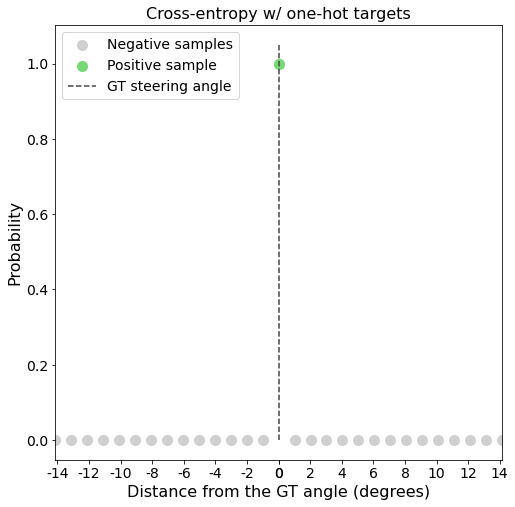

In [4]:
bound = 4.5
target = 0
n_samples = 513


fig, ax = plt.subplots(1, 1, figsize=(8, 8))

tick_formatter = FuncFormatter(lambda x, pos: int(bin_idx_to_steering_angle(x, num_samples=n_samples, bound=bound).round()))
bin_indices = steering_angle_to_bin_idx(np.concatenate([np.arange(0.5, -15, -2),(np.arange(0.5, 15, 2))]))
tick_locator = FixedLocator(bin_indices)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.set_major_formatter(tick_formatter)
ax.xaxis.set_major_locator(tick_locator)
ax.set_xlim(242, 270)

samples = torch.linspace(-bound, bound, n_samples)
distances = torch.abs(samples - target)**2
probs = torch.zeros_like(samples, dtype=torch.int32)
probs[256] = 1

ax.set_title('Cross-entropy w/ one-hot targets', fontsize=16)
ax.set_xlabel('Distance from the GT angle (degrees)', fontsize=16)
ax.set_ylabel('Probability', fontsize=16)

samples = steering_angle_to_bin_idx(np.degrees(samples), num_samples=n_samples, bound=bound)

ax.scatter(samples, probs, s=100, color='#d0d0d0', label=f'Negative samples', alpha=1)
ax.scatter(samples[256], probs[256], s=100, color='#76D975', label=f'Positive sample')
ax.vlines(256, 0, torch.max(probs)+0.05, color='#444', linestyle='--', label='GT steering angle')
ax.legend(fontsize=14, loc='upper left')

plt.show()
fig.savefig('ce-one-hot-targets.png')

### Making a working version

In [88]:
T = 0.05

target = torch.rand((512, 1)) * 2 * bound - bound # 512 x 1

# Generate N negatives, one for each element in the batch: (B, N, D).
negatives = torch.rand((batch_size, n_samples, 1)) * 2 * bound - bound # 512 x 1024 x 1

# Merge target and negatives: (B, N+1, D).
targets = torch.cat([target.unsqueeze(dim=1), negatives], dim=1) # 512 x 1025 x 1
print(f'merged targets (should be [B, N+1, D]): {targets.shape} {targets.dtype}')

# Generate a random permutation of the positives and negatives.
permutation = torch.rand(targets.size(0), targets.size(1)).argsort(dim=1)
print(f'permutation: {permutation.shape} {permutation.dtype}')
targets = targets[torch.arange(targets.size(0)).unsqueeze(-1), permutation]
print(f'permuted targets: {targets.shape} {targets.dtype}')

# Get the original index of the positive. This will serve as the class label
# for the loss.
gt_indices = (permutation == 0).nonzero()[:, 1]
gt_values = targets[range(targets.shape[0]), gt_indices]
distances_from_gt = torch.abs(targets - gt_values.unsqueeze(dim=1))**2
ground_truth = torch.softmax(-distances_from_gt/T, dim=1).squeeze() # gaussian around correct answer

print(f'gt probs: {ground_truth.shape} {ground_truth.dtype}')

# make ground truth indices into a one-hot vector
# ground_truth = torch.zeros_like(targets)
# ground_truth[torch.arange(ground_truth.size(0)).unsqueeze(-1), ground_truth_indices.unsqueeze(-1)] = 1

merged targets (should be [B, N+1, D]): torch.Size([512, 1025, 1]) torch.float32
permutation: torch.Size([512, 1025]) torch.int64
permuted targets: torch.Size([512, 1025, 1]) torch.float32
ground truth: torch.Size([512]) torch.int64
ground truth values: torch.Size([512, 1]) torch.float32
distances from gt: torch.Size([512, 1025, 1]) torch.float32
gt probs: torch.Size([512, 1025]) torch.float32


In [90]:
ground_truth_values[0]

tensor([-3.1949])

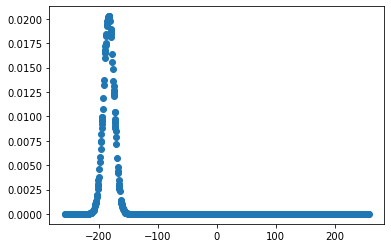

In [89]:
plt.scatter(np.degrees(targets[0]), gt_probs[0])

inputs: torch.Size([512, 3, 68, 264]) torch.float32
target: torch.Size([512, 1]) torch.float32
merged targets (should be [B, N+1, D]): torch.Size([512, 513, 1]) torch.float32
permutation: torch.Size([512, 513]) torch.int64
permuted targets: torch.Size([512, 513, 1]) torch.float32

### How a trained model's energy looks like

In [63]:
import glob

# normal = np.load('../ebm-512-s1_energy_0.npy')
# tempreg = np.load('../ebm-normal-1-s1_energy_0.npy')
# spatial = np.load('../ebm-spatial-0-s2_energy_0.npy')

normal_paths = glob.glob('../ebm-512-s1_energy_*.npy')
# normal_paths = [x for x in normal_paths if int(x.split('_')[-1].split('.')[0]) > 100]
normal_paths.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# tempreg_paths = glob.glob('../ebm-normal-1-s1_energy_1**.npy')
# tempreg_paths.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

spatial_paths = glob.glob('../ebm-spatial-0-s2_energy_*.npy')
# spatial_paths = [x for x in spatial_paths if int(x.split('_')[-1].split('.')[0]) > 100]
spatial_paths.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

normal = np.vstack([np.load(path) for path in normal_paths])
# tempreg = np.vstack([np.load(path) for path in tempreg_paths])
spatial = np.vstack([np.load(path) for path in spatial_paths])

normal.shape, spatial.shape

((11, 512), (11, 512))

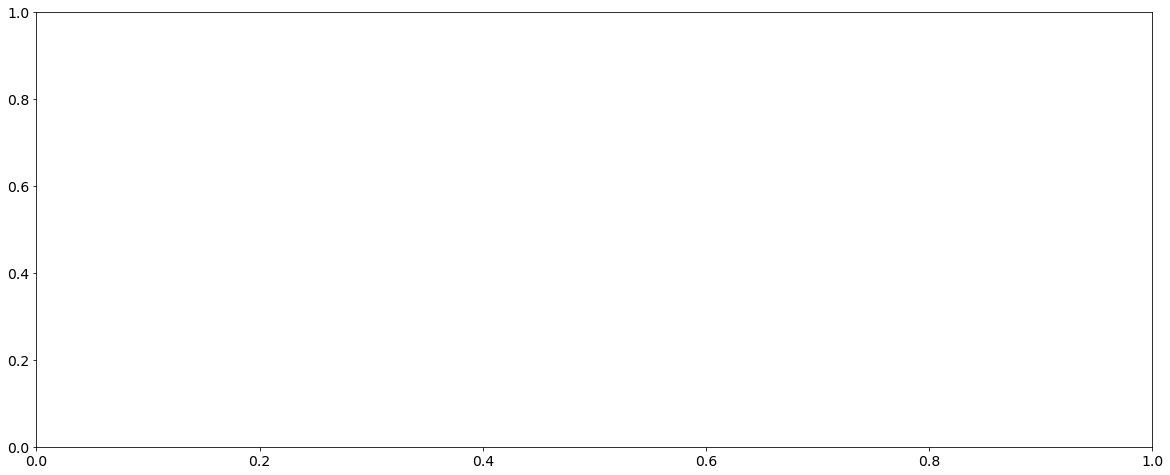

In [86]:
fig, ax = plt.subplots(1, figsize=(20,8))

# make a video from the energy plots, using cv2
import cv2
import glob
import os


def make_video(images, outvid=None, fps=5, size=None,):
    """
    Create a video from a list of images.

    @param      images      list of images to use in the video
    @param      outvid      output video
    @param      fps         frame per second
    @param      size        size of each frame
    @return                 Nothing
    """
    if not outvid:
        outvid = 'outvid.avi'
    if not size:
        size = images[0].shape[1], images[0].shape[0]
    out = cv2.VideoWriter(outvid, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    for image in images:
        out.write(image)
    out.release()

os.makedirs('video_tmp', exist_ok=True)

for idx in range(len(normal)):

    tick_formatter = FuncFormatter(lambda x, pos: int(bin_idx_to_steering_angle(x, num_samples=n_samples, bound=bound).round()))
    bin_indices = steering_angle_to_bin_idx(np.concatenate([np.arange(0.5, -250, -45),(np.arange(0.5, 250, 45))]))
    tick_locator = FixedLocator(bin_indices)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.xaxis.set_major_locator(tick_locator)

    # min_angle_normal = steering_angle_to_bin_idx()
    min_angle_spatial = steering_angle_to_bin_idx(np.argmin(spatial[idx]))

    ax.set_title('Step %d' % idx, fontsize=16)
    ax.plot(np.arange(normal.shape[1]), normal[idx], label='normal')
    ax.vlines(np.argmin(normal[idx]), np.min(normal[idx]), 0, color='lightblue', label='normal prediction', linestyle='--')
    # ax.plot(tempreg[idx], label='tempreg')
    ax.plot(np.arange(normal.shape[1]), spatial[idx], label='spatial')
    ax.vlines(np.argmin(spatial[idx]), np.min(spatial[idx]), 0, color='orange', label='spatial prediction', linestyle='--')
    # plt.xlim(200, 250)

    ax.legend()
    fig.savefig('video_tmp/energy_%d.png' % idx)
    ax.clear()

images = [cv2.imread(file) for file in sorted(glob.glob('video_tmp/energy_*.png'), key=lambda x: int(x.split('_')[-1].split('.')[0]))]
make_video(images, outvid='energy_video.mp4', fps=3)